In [53]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
# from dataset import JasperRidgeDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

from dataset import Samson, JasperRidge


In [54]:
path = '/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/'

M_est_jasper = torch.tensor(sio.loadmat(path+'jasper.mat')['ebk'])
M_est_samson = torch.tensor(sio.loadmat(path+'samson.mat')['ebk'])

samson_dataset = Samson(config.Samson_PATH)
jasper_dataset = JasperRidge(config.JasperRidge_PATH)
samson_wv = np.array(samson_dataset.wv, dtype=np.uint)
jasper_wv = np.array(jasper_dataset.wv, dtype=np.uint)


In [55]:
from dataset import JasperRidge

jasper_dataset = JasperRidge(config.JasperRidge_PATH)
dataset_name = 'JasperRidge'
jasper_wv = np.array(jasper_dataset.wv, dtype=np.uint)

jasper_result_path = os.path.join(config.RESULTS_PATH, 'jasperRidge')

In [56]:
from HySpecLab.unmixing import ContrastiveUnmixing
model = ContrastiveUnmixing(jasper_dataset.n_bands, jasper_dataset.n_endmembers)

model.load_state_dict(torch.load(os.path.join(jasper_result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/media/abian/Extreme SSD/Thesis/CLHU/review/jasperRidge/clhu/weights/clhu.pth'

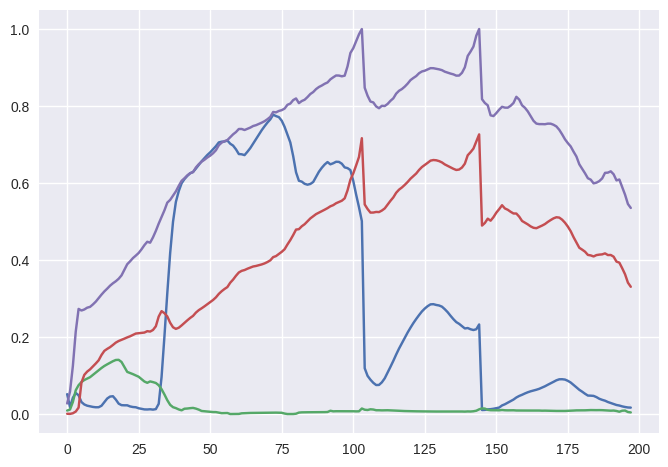

In [4]:
M_est_jasper = torch.sigmoid(model.ebk.detach())

plt.plot(M_est_jasper.numpy().T)
plt.show()

In [5]:
from dataset import Samson

samson_dataset = Samson(config.Samson_PATH)
samson_wv = np.array(samson_dataset.wv, dtype=np.uint)

samson_result_path = os.path.join(config.RESULTS_PATH, 'samson')

In [6]:
model = ContrastiveUnmixing(samson_dataset.n_bands, samson_dataset.n_endmembers)

model.load_state_dict(torch.load(os.path.join(samson_result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

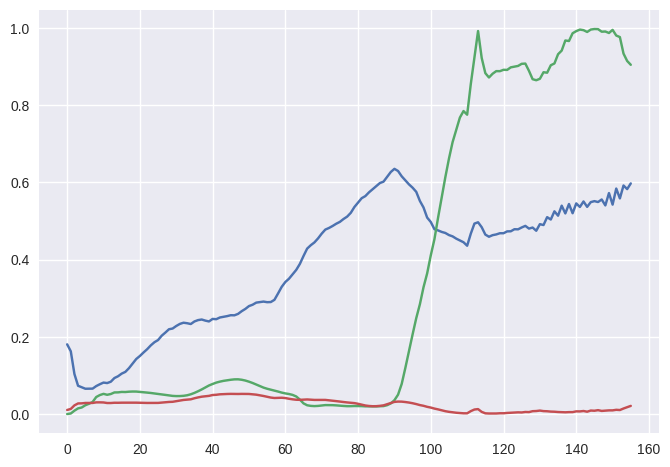

In [7]:
M_est_samson = torch.sigmoid(model.ebk.detach())

plt.plot(M_est_samson.numpy().T)
plt.show()

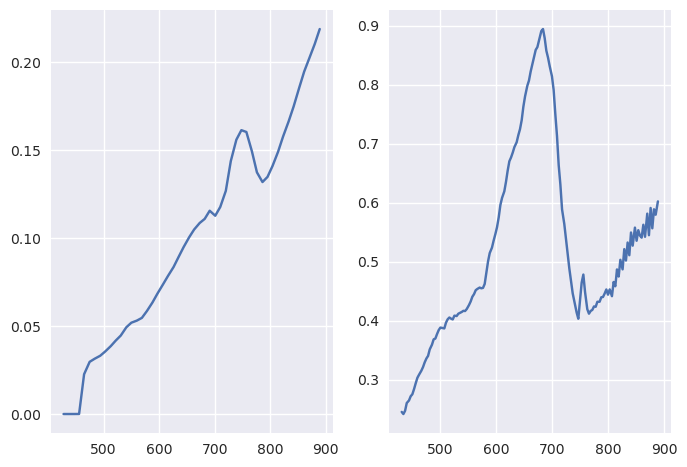

In [27]:
plt.subplot(1,2,1)
plt.plot(jasper_wv[:50], M_est_jasper.T[:50, 2])
plt.subplot(1,2,2)
plt.plot(samson_wv[10:], M_est_samson.T[10:, 0])
plt.show()

In [28]:
# get the indices of the values more closes to the wavelengths of jasper

idx = []
for wv in jasper_wv[:50]:
    idx.append(np.argmin(np.abs(samson_wv - wv)))

idx = np.array(idx)
samson_wv[idx]

array([429, 438, 448, 457, 467, 476, 486, 495, 504, 514, 523, 533, 542,
       552, 561, 571, 580, 589, 599, 608, 618, 627, 637, 646, 656, 665,
       674, 684, 693, 703, 712, 722, 731, 741, 750, 759, 769, 778, 788,
       797, 807, 816, 826, 835, 844, 854, 863, 870, 882, 889],
      dtype=uint64)

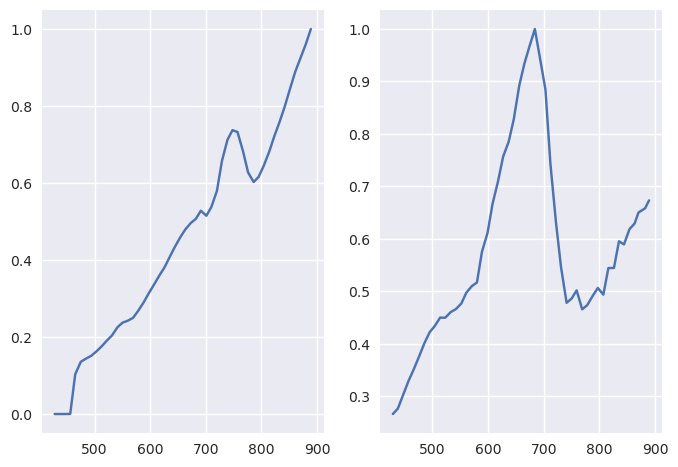

In [29]:
plt.subplot(1,2,1)
i = 0
plt.plot(jasper_wv[i:50+i], M_est_jasper.T[i:50+i, 2]/M_est_jasper.T[i:50+i, 2].max())
plt.subplot(1,2,2)
i = 0
# plt.plot(samson_wv[idx-1], M_est_samson.T[idx-1, 0]/M_est_samson.T[idx-1, 0].max())
plt.plot(samson_wv[idx-i], M_est_samson.T[idx-i, 0]/M_est_samson.T[idx-i, 0].max())

plt.show()

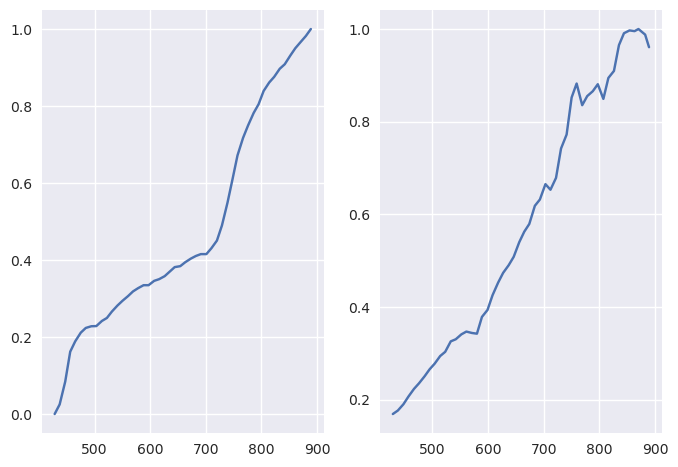

In [30]:
plt.subplot(1,2,1)
plt.plot(jasper_wv[:50], jasper_dataset.endmembers().T[:50, 2]/jasper_dataset.endmembers().T[:50, 2].max())
plt.subplot(1,2,2)
plt.plot(samson_wv[idx], samson_dataset.endmembers().T[idx, 0]/samson_dataset.endmembers().T[idx, 0].max())
plt.show()

In [33]:
jasper_soil = M_est_jasper.T[:50, 2]
samson_soil = M_est_samson.T[idx, 0]
jasper_soil_ref = jasper_dataset.endmembers().T[:50, 2]
samson_soil_ref = samson_dataset.endmembers().T[idx, 0]

jasper_soil = torch.stack([jasper_soil, jasper_soil_ref], axis=0)
samson_soil = torch.stack([samson_soil, samson_soil_ref], axis=0)
sad(jasper_soil, samson_soil)

tensor([[0.4907, 0.1384],
        [0.5346, 0.1496]])

In [34]:
jasper_soil.shape

torch.Size([2, 50])

In [35]:
jasper_soil = jasper_dataset.endmembers().T[:50, 2]
samson_soil = samson_dataset.endmembers().T[idx, 0]
sad(jasper_soil.reshape(1, -1), samson_soil.reshape(1, -1))

tensor(0.1496)

In [36]:
jasper_soil = M_est_jasper.T[:50, 2]
samson_soil = samson_dataset.endmembers().T[idx, 0]
sad(jasper_soil.reshape(1, -1), samson_soil.reshape(1, -1))

tensor(0.1384)

In [37]:
jasper_soil = jasper_dataset.endmembers().T[:50, 2]
samson_soil = M_est_samson.T[idx, 0]
sad(jasper_soil.reshape(1, -1), samson_soil.reshape(1, -1))

tensor(0.5346)

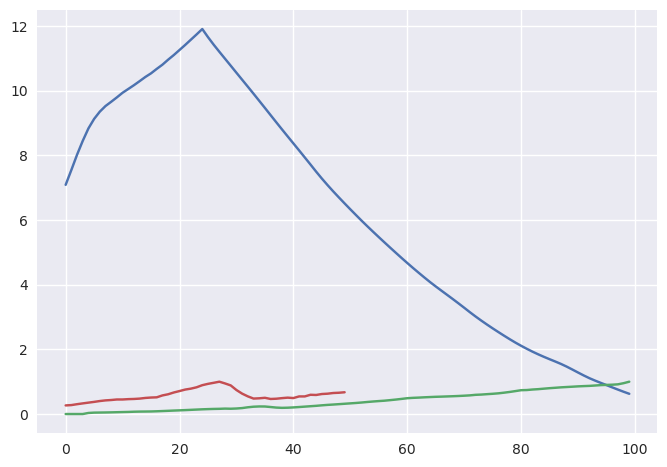

In [38]:
# jasper_soil = M_est_jasper.T[:100, 2]/jasper_soil.max()
# samson_soil = M_est_samson.T[idx, 0]/samson_soil.max()

jasper_soil = M_est_jasper.T[:100, 2]
samson_soil = M_est_samson.T[idx, 0]

cov = np.correlate(samson_soil, jasper_soil, mode='same')
plt.plot(cov)
plt.plot(jasper_soil/jasper_soil.max())
plt.plot(samson_soil/samson_soil.max())
plt.show()


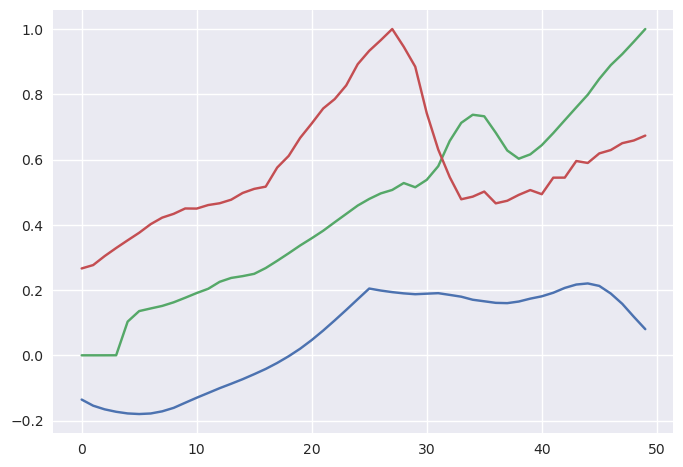

44

In [39]:
jasper_soil = M_est_jasper.T[:50, 2]
samson_soil = M_est_samson.T[idx, 0]

# self implementation of cross-correlation
def cross_correlation(x, y):
    x = x - x.mean()
    y = y - y.mean()
    return np.correlate(x, y, mode='same')

cov = cross_correlation(jasper_soil, samson_soil,)
plt.plot(cov)
plt.plot(jasper_soil/jasper_soil.max())
plt.plot(samson_soil/samson_soil.max())

plt.show()

cov.argmax()

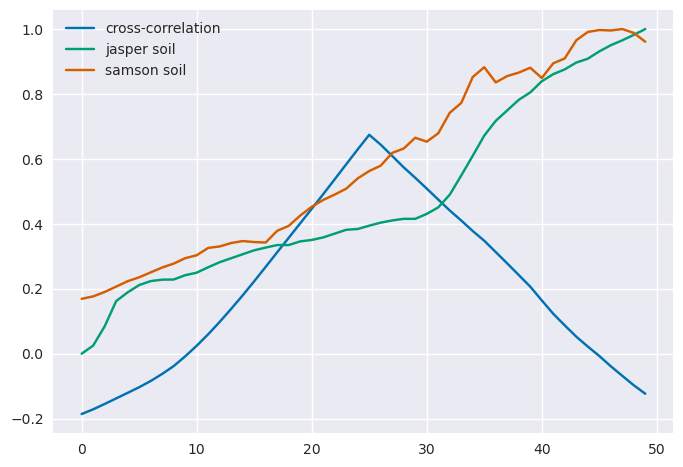

25

In [41]:
jasper_soil = jasper_dataset.endmembers().T[:50, 2]
samson_soil = samson_dataset.endmembers().T[idx, 0]

# self implementation of cross-correlation
def cross_correlation(x, y):
    x = x - x.mean()
    y = y - y.mean()
    return np.correlate(x, y, mode='same')

cov = cross_correlation(jasper_soil, samson_soil,)
with plt.style.context('seaborn-colorblind'):    
    plt.plot(cov, label='cross-correlation')
    plt.plot(jasper_soil/jasper_soil.max(), label='jasper soil')
    plt.plot(samson_soil/samson_soil.max(), label='samson soil')

plt.legend()
plt.show()

cov.argmax()

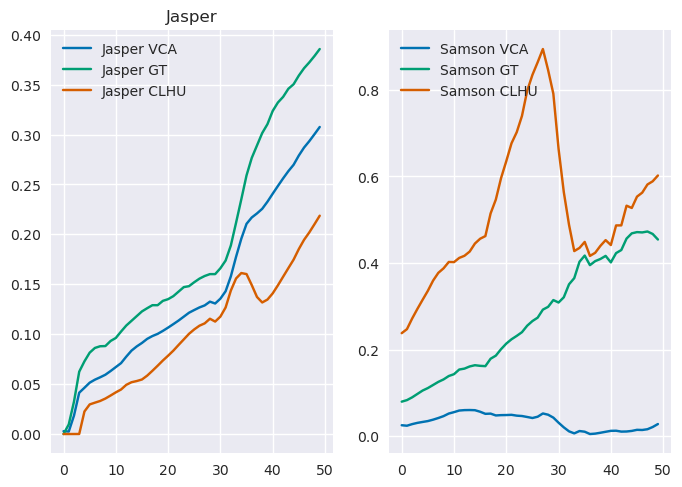

In [42]:
from scipy import io as sio
M_vca_jasper = sio.loadmat('/media/abian/Extreme SSD/Thesis/CLHU/results/jasperRidge/matlab/endmember_estimation')['VCA']
M_vca_samson = sio.loadmat('/media/abian/Extreme SSD/Thesis/CLHU/results/samson/matlab/endmember_estimation')['VCA']

with plt.style.context('seaborn-colorblind'):
    plt.subplot(1,2,1)
    plt.title('Jasper')
    plt.plot(M_vca_jasper.T[:50, 2], label='Jasper VCA')
    plt.plot(jasper_dataset.endmembers().T[:50, 2], label='Jasper GT')
    plt.plot(M_est_jasper.T[:50, 2], label='Jasper CLHU')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(M_vca_samson.T[idx, 2], label='Samson VCA')
    plt.plot(samson_dataset.endmembers().T[idx, 0], label='Samson GT')
    plt.plot(M_est_samson.T[idx, 0], label='Samson CLHU')
    plt.legend()
plt.show()

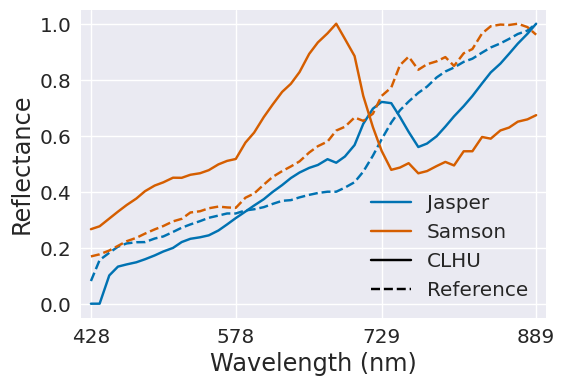

In [65]:
jasper_soil_clhu = M_est_jasper.T[2:52, 2].clone()

jasper_soil_clhu[36:] = jasper_soil_clhu[36:] * 0.95 

samson_soil_clhu = M_est_samson.T[idx, 0]
jasper_soil_ref = jasper_dataset.endmembers().T[2:52, 2]
samson_soil_ref = samson_dataset.endmembers().T[idx, 0]

jasper_soil_clhu = jasper_soil_clhu/jasper_soil_clhu.max()
samson_soil_clhu = samson_soil_clhu/samson_soil_clhu.max()
jasper_soil_ref = jasper_soil_ref/jasper_soil_ref.max()
samson_soil_ref = samson_soil_ref/samson_soil_ref.max()

wv = jasper_wv[:50]
n_ticks=4
x_ticks = np.linspace(1, len(wv), n_ticks, dtype=int)

with plt.style.context('seaborn-colorblind'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig = plt.figure(figsize=(6,4))
    plt.plot(wv, jasper_soil_clhu, "-", color=colors[0], label='Jasper')
    plt.plot(wv, jasper_soil_ref, "--", color=colors[0])
    plt.plot(wv, samson_soil_clhu, "-", color=colors[2], label='Samson')
    plt.plot(wv, samson_soil_ref, "--", color=colors[2])

    plt.plot(0, "-", label='CLHU', color='black')
    plt.plot(0, "--", label='Reference', color='black')

    plt.xticks(wv[x_ticks-1])

    plt.ylabel('Reflectance', fontsize='xx-large')
    plt.xlabel('Wavelength (nm)', fontsize='xx-large')

    ticks_range = wv[x_ticks-1][0], wv[x_ticks-1][-1]
    plt.xlim(ticks_range[0] - 10.25, ticks_range[1] + 10.25)

    plt.tick_params(axis='both', labelsize='x-large')
    plt.legend(loc='lower right', fontsize='x-large')

plt.show()

# save_dir = os.path.join(config.RESULTS_PATH, 'other')
save_dir = '/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/'
fig.savefig(os.path.join(save_dir, 'soil_endmember_comparison.pdf'), bbox_inches='tight')

In [33]:
from dataset import Apex

apex_dataset = Apex(config.Apex_PATH)
apex_wv = np.array(apex_dataset.wv, dtype=np.uint)

apex_result_path = os.path.join(config.RESULTS_PATH, 'apex')

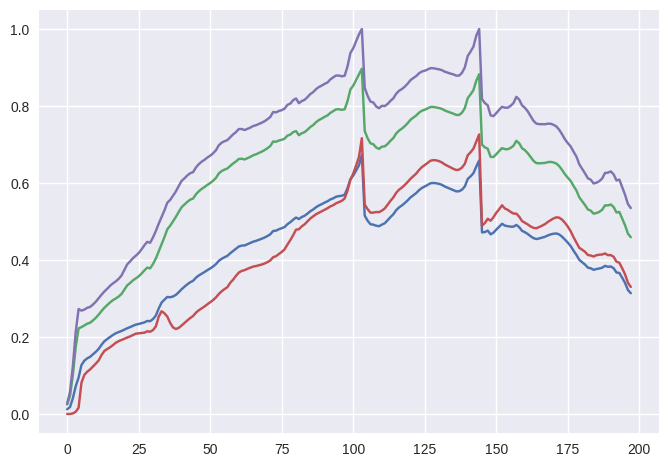

tensor([[0.8657, 0.0607, 0.0519, 0.0217],
        [0.0102, 0.9796, 0.0076, 0.0026],
        [0.0736, 0.1450, 0.5176, 0.2638],
        [0.0575, 0.0432, 0.1126, 0.7868]])

In [34]:
from HySpecLab.unmixing import ContrastiveUnmixing
# Jasper Model
jasper_model = ContrastiveUnmixing(jasper_dataset.n_bands, jasper_dataset.n_endmembers)

jasper_model.load_state_dict(torch.load(os.path.join(jasper_result_path, 'clhu/weights/clhu.pth')))
jasper_model = jasper_model.eval()

# Samson Model
samson_model = ContrastiveUnmixing(samson_dataset.n_bands, samson_dataset.n_endmembers)

samson_model.load_state_dict(torch.load(os.path.join(samson_result_path, 'clhu/weights/clhu.pth')))
samson_model = samson_model.eval()

# Apex Model
apex_model = ContrastiveUnmixing(apex_dataset.n_bands, apex_dataset.n_endmembers)

apex_model.load_state_dict(torch.load(os.path.join(apex_result_path, 'clhu/weights/clhu.pth')))
apex_model = apex_model.eval()


# Endmembers
with torch.no_grad():
    jasper_m = torch.sigmoid(jasper_model.ebk.detach())
    jasper_m_hat = jasper_model(jasper_m)

    samson_m = torch.sigmoid(samson_model.ebk.detach())
    samson_m_hat = samson_model(samson_m)

    apex_m = torch.sigmoid(apex_model.ebk.detach())
    apex_m_hat = apex_model(apex_m)

plt.plot(jasper_m_hat[2:].T.cpu())
plt.plot(jasper_m[2:].T.cpu())
plt.show()

torch.softmax(jasper_model.A, dim=1)

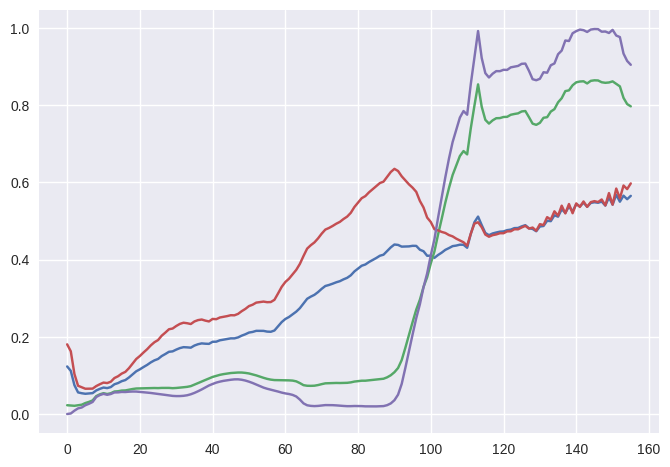

tensor([[0.6741, 0.1761, 0.1498],
        [0.1216, 0.7988, 0.0795],
        [0.0204, 0.0123, 0.9673]])

In [27]:
plt.plot(samson_m_hat[:2].T.cpu())
plt.plot(samson_m[:2].T.cpu())
plt.show()

torch.softmax(samson_model.A, dim=1)

In [36]:
np.diagonal(sad(jasper_m, jasper_dataset.endmembers())).mean(), np.diagonal(sad(jasper_m_hat, jasper_dataset.endmembers())).mean() 

(0.182556, 0.10549411)

In [39]:
np.diagonal(sad(samson_m, samson_dataset.endmembers())).mean(), np.diagonal(sad(samson_m_hat, samson_dataset.endmembers())).mean() 

(0.19641297, 0.10850216)

In [40]:
np.diagonal(sad(apex_m, apex_dataset.endmembers())).mean(), np.diagonal(sad(apex_m_hat, apex_dataset.endmembers())).mean()

(0.110051356, 0.1051891)

In [47]:
import pandas as pd
df = pd.DataFrame({'Jasper': [np.diagonal(sad(jasper_m, jasper_dataset.endmembers())).mean(), np.diagonal(sad(jasper_m_hat, jasper_dataset.endmembers())).mean()],
                     'Samson': [np.diagonal(sad(samson_m, samson_dataset.endmembers())).mean(), np.diagonal(sad(samson_m_hat, samson_dataset.endmembers())).mean()],
                     'Apex': [np.diagonal(sad(apex_m, apex_dataset.endmembers())).mean(), np.diagonal(sad(apex_m_hat, apex_dataset.endmembers())).mean()]},
                     index=['M', 'CLHU(M)'])

df.to_latex("table.tex")

/tmp/ipykernel_8626/3895973922.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex("table.tex")
